### Data Exploration and Processing 

In [1]:
# Importing standards python libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import string
%matplotlib inline

In [2]:
data = pd.read_csv("IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.shape

(50000, 2)

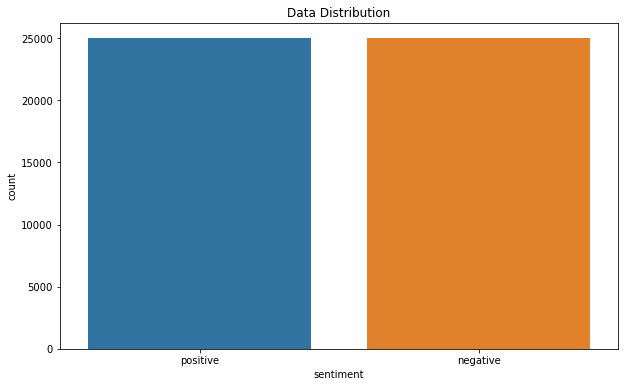

In [4]:
plt.figure(figsize = (10,6))
plt.title("Data Distribution")
sns.countplot(x = "sentiment", data = data)

plt.show()

In [5]:
data['lenght'] = data['review'].apply(lambda x : len(x.split()))

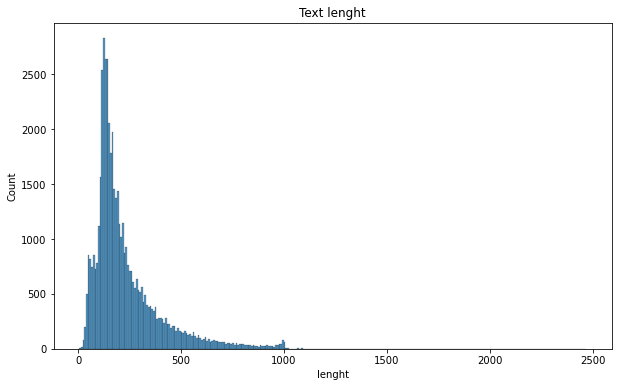

In [6]:
plt.figure(figsize = (10,6))
plt.title("Text lenght")

sns.histplot(x="lenght", data = data)
plt.show()

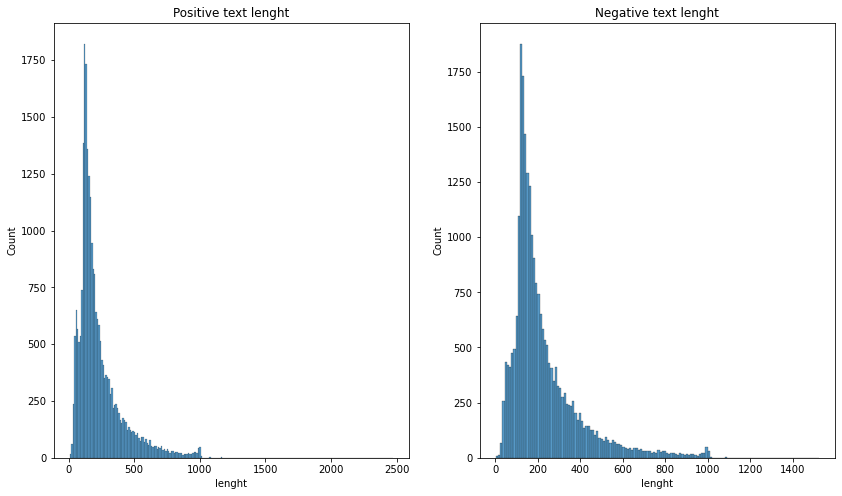

In [7]:
fig = plt.figure(figsize = (14,8))
ax1 = fig.add_subplot(121)
plt.title("Positive text lenght")
sns.histplot(x="lenght", data = data[data['sentiment'] == 'positive'], ax=ax1)

ax2 = fig.add_subplot(122)
plt.title("Negative text lenght")
sns.histplot(x="lenght", data = data[data['sentiment'] == 'negative'], ax=ax2)

plt.show()

In [8]:
data.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [9]:
def clean_review(text):
    clean_text = re.sub('<br\s?\/>|<br>', '', text) 
    clean_text = re.sub('[^a-zA-Z\']', ' ', clean_text)
    clean_text = clean_text.lower()
    return clean_text

In [10]:
data['review'] = data['review'].apply(lambda x : clean_review(x))

In [11]:
data.iloc[1,0]

"a wonderful little production  the filming technique is very unassuming  very old time bbc fashion and gives a comforting  and sometimes discomforting  sense of realism to the entire piece  the actors are extremely well chosen  michael sheen not only  has got all the polari  but he has all the voices down pat too  you can truly see the seamless editing guided by the references to williams' diary entries  not only is it well worth the watching but it is a terrificly written and performed piece  a masterful production about one of the great master's of comedy and his life  the realism really comes home with the little things  the fantasy of the guard which  rather than use the traditional 'dream' techniques remains solid then disappears  it plays on our knowledge and our senses  particularly with the scenes concerning orton and halliwell and the sets  particularly of their flat with halliwell's murals decorating every surface  are terribly well done "

## Modelling

#### Bag of Words

In [12]:
# Splitting the data into train set and validation set
train_data = data[:30000]
val_data = data[30000:]

For efficient processing we will disable some pipline component like parser and named entity recognition 

In [13]:
import spacy

# Create an empty model
nlp = spacy.blank("en")

# Create custom TextCategorizer with exclusive classes and bag of words architecture
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)
print(nlp.pipe_names)

['textcat']


In [14]:
textcat.add_label("positive")
textcat.add_label("negative")

1

In [15]:
# Data Preparation
train_texts = train_data['review'].values
train_labels = [{'cats': {'positive': label == 'positive','negative': label == 'negative'}} 
                for label in train_data['sentiment']]

In [16]:
from spacy.util import minibatch
import random

def model_train(model, train, optimizer):
    losses = {}
    random.seed(1)
    random.shuffle(train)
    
    batches = minibatch(train, size=8)
    for batch in batches:
        texts, labels = zip(*batch)
        model.update(texts, labels, sgd=optimizer, losses=losses)
        
    return losses

In [17]:
# 1st Iteration
spacy.util.fix_random_seed(1)
random.seed(1)
optimizer = nlp.begin_training()
train = list(zip(train_texts, train_labels))
losses = model_train(nlp, train, optimizer)
print(losses['textcat'])

13.035159206988384


Prediction:

In [19]:
data.iloc[30001,:2]

review       this is one of the silliest movies i have ever...
sentiment                                             negative
Name: 30001, dtype: object

In [20]:
doc = nlp(data.iloc[30001,0])
print(doc.cats)

{'positive': 5.7470437297979515e-08, 'negative': 1.0}


In [21]:
# Predict list of reviews
def predict(nlp, texts): 

    docs = [nlp.tokenizer(text) for text in texts]    
    # Use textcat to get the scores for each doc
    textcat = nlp.get_pipe('textcat')
    predicted_class = textcat.predict(docs)[0].argmin(axis=1)
    
    return predicted_class

In [22]:
data.iloc[30001:30004,:2]

,review,sentiment
30001,this is one of the silliest movies i have ever...,negative
30002,for some reason my father in law gave me a cop...,negative
30003,it may be hard to explain how but this film i...,positive


In [23]:
# Negative review -> 0; positive review -> 1
predict(nlp, list(data.iloc[30001:30004,0].values))

array([0, 0, 1], dtype=int64)

In [24]:
from sklearn.metrics import accuracy_score, f1_score

In [25]:
mapper = {'positive':1, 'negative':0}
val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])

<ipython-input-25-729d24dc246a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])


In [26]:
val_data.sentiment.values

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
def evaluate(model, texts, labels): 
    predicted_class = predict(model, texts)
    accuracy = accuracy_score(predicted_class, labels)
    fscore = f1_score(predicted_class, labels)
    return accuracy, fscore

In [28]:
accuracy, f1score = evaluate(nlp, list(val_data.review.values), val_data.sentiment.values)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1_score: {f1score:.4f}")

Accuracy: 0.8791
F1_score: 0.8777


In [29]:
# Model Training 
n_iters = 4
for i in range(n_iters):
    losses = model_train(nlp, train, optimizer)
    accuracy, f1score = evaluate(nlp, list(val_data.review.values), val_data.sentiment.values)
    print(f"Loss: {losses['textcat']:.3f} \t Accuracy: {accuracy:.3f} \t F1_Score: {f1score:.3f}")

Loss: 7.169 	 Accuracy: 0.879 	 F1_Score: 0.881
Loss: 5.249 	 Accuracy: 0.871 	 F1_Score: 0.863
Loss: 3.843 	 Accuracy: 0.878 	 F1_Score: 0.873
Loss: 2.865 	 Accuracy: 0.880 	 F1_Score: 0.881


In [33]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stp = set(stopwords.words('english'))

WordCloud of positive reviews, It is better to add some words to our stopwords set such as: movie, film, story ... because such words may appear in both positive and negative reviews. 

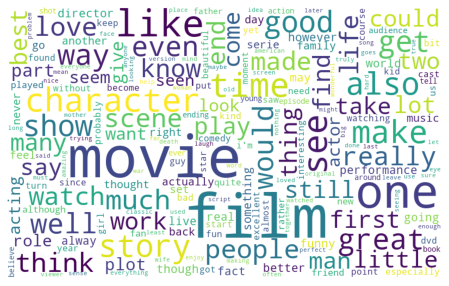

In [37]:
poswords = ' '.join([text for text in train_data[train_data['sentiment'] == 'positive']['review']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, stopwords=stp,
                      background_color='white').generate(poswords)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### CNN

In [39]:
del nlp, textcat, optimizer

In [40]:
nlp = spacy.blank("en")

# Create custom TextCategorizer with exclusive classes and cnn architecture
textcat = nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat)
print(nlp.pipe_names)

['textcat']


In [41]:
textcat.add_label("positive")
textcat.add_label("negative")

1

Train a CNN architecture needs many resources (RAM), I will use a small subset of data.

In [42]:
def load_data(data):
    # Splitting the data into train set and validation set
    train_data = data[:10000]
    val_data = data[10000:13000]
    mapper = {'positive':1, 'negative':0}
    val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])
    train_texts = train_data['review'].values
    train_labels = [{'cats': {'positive': label == 'positive','negative': label == 'negative'}} 
                for label in train_data['sentiment']]
    return list(zip(train_texts, train_labels)), list(val_data.review.values), val_data.sentiment.values

In [43]:
n_iters = 1
spacy.util.fix_random_seed(1)
random.seed(1)
optimizer = nlp.begin_training()
train, valrev, valsnt = load_data(data)
for i in range(n_iters):
    losses = model_train(nlp, train, optimizer)
    accuracy, f1score = evaluate(nlp, valrev, valsnt)
    print(f"Loss: {losses['textcat']:.3f} \t Accuracy: {accuracy:.3f} \t F1_Score: {f1score:.3f}")

<ipython-input-42-b1c471c1393d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['sentiment'] = val_data['sentiment'].apply(lambda x : mapper[x])


Loss: 6.095 	 Accuracy: 0.800 	 F1_Score: 0.747
